In [ ]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-38bq9crb
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-38bq9crb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.3MB 10.4MB/s 
     |████████████████████████████████| 901kB 33.9MB/s 
  Created wheel for transformers: filename=transformers-4.8.0.dev0-cp37-none-any.whl size=2474626 sha256=b3b2ed32ff4d33dff4c2e4ea3f4294741d168e690ed3d634f7fe0693eb3da364
  Stored in directory: /tmp/pip-ephem-wheel-cache-9x47nuho/wheels/70/d3/52/b3fa4f8b8ef04167ac62e5bb2accb62ae764db2a378247490e
Successfully built transformers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os 
os.chdir("/content/drive/My Drive/internn/data")

Mounted at /content/drive


In [ ]:
from sen_loader import *

In [ ]:
from transformers import BertPreTrainedModel
from transformers.models.bert.modeling_bert import *

class BertModelCustom(BertPreTrainedModel):

    def __init__(self, config, add_pooling_layer=True):
        super().__init__(config)
        self.config = config

        self.embeddings = CustomBertEmbeddings(config)
        self.encoder = BertEncoder(config)

        self.pooler = BertPooler(config) if add_pooling_layer else None

        self.init_weights()
        
        self.lin2 = nn.Linear(768, config.vocab_size-2)
        self.cls = BertOnlyMLMHead(config)

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):

        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if self.config.is_decoder:
            use_cache = use_cache if use_cache is not None else self.config.use_cache
        else:
            use_cache = False

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
            batch_size, seq_length = input_shape
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
            batch_size, seq_length = input_shape
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        device = input_ids.device if input_ids is not None else inputs_embeds.device

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        if attention_mask is None:
            attention_mask = torch.ones(((batch_size, seq_length + past_key_values_length)), device=device)
        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask: torch.Tensor = self.get_extended_attention_mask(attention_mask, input_shape, device)

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.config.is_decoder and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)


        embedding_output = self.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            token_type_ids=token_type_ids,
            inputs_embeds=inputs_embeds,
            past_key_values_length=past_key_values_length,
        )

        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_extended_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        # pooled_output = self.pooler(sequence_output) if self.pooler is not None else None
        
        prediction_scores = self.cls(sequence_output)
        output = self.lin2(sequence_output)
        return output, prediction_scores

        # if not return_dict:
        #     return (sequence_output, pooled_output) + encoder_outputs[1:]

        # return BaseModelOutputWithPoolingAndCrossAttentions(
        #     last_hidden_state=sequence_output,
        #     pooler_output=pooled_output,
        #     past_key_values=encoder_outputs.past_key_values,
        #     hidden_states=encoder_outputs.hidden_states,
        #     attentions=encoder_outputs.attentions,
        #     cross_attentions=encoder_outputs.cross_attentions,
        # )




class CustomBertEmbeddings(nn.Module):
    """Construct the embeddings from word, position and token_type embeddings."""

    def __init__(self, config):
        super().__init__()

        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        self.register_buffer("position_ids", torch.arange(config.max_position_embeddings).expand((1, -1)))
        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")

    def forward(
        self, input_ids=None, token_type_ids=None, position_ids=None, inputs_embeds=None, past_key_values_length=0
    ):
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]

        
        if position_ids is None:
            position_ids = self.position_ids[:, past_key_values_length : seq_length + past_key_values_length]
            # print(position_ids.shape)
            # print(position_ids)
        
        if token_type_ids is None:
            token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=self.position_ids.device)

        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)

        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        
        embeddings = inputs_embeds + token_type_embeddings
        if self.position_embedding_type == "absolute":
            position_embeddings = self.position_embeddings(position_ids)
            embeddings += position_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)

        
        return embeddings

In [ ]:
text = 'abcdefghi jklmnopqrstuvwxyz'
corpus = [char for char in text]
mask_id = len(corpus) + 1
vocab_size = mask_id + 2

In [ ]:
train_dataset = SentenceDataset(PATH='./data/train_test_sentenceDataset.pt', which='Embeddings')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = SentenceDataset(PATH='./data/train_test_sentenceDataset.pt', which='Embeddings', train=False)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

In [ ]:
def num_to_letter(num):
    x = chr(num + 96)
    
    if x == '`':
        x = " "
    return x

def get_text(tnsr):
  text = ''
  for value in tnsr:
    c = num_to_letter(value.item())
    text = text + c
  return text

In [ ]:
sample = next(iter(train_dataset))
print("Batch Data Shape = ", sample[0].squeeze(0).shape)
print("Num Batch Labels = ", sample[1].squeeze(0).shape)
print("Output shape: ", sample[2].shape)
print("Sen Lengths: ", sample[3])

Batch Data Shape =  torch.Size([31, 512])
Num Batch Labels =  torch.Size([31])
Output shape:  torch.Size([31, 27])
Sen Lengths:  31


In [ ]:
print(get_text(sample[1]))

the project gutenberg ebook of 


In [ ]:
import copy
import numpy as np

def get_inputs(text, mask_index = None):
  n = len(text)
  if not mask_index:
    mask_index = np.random.randint(0,n)
  
  ids = []
  for char in text:
    ids.append(corpus.index(char))
  input_ids = torch.tensor(ids).unsqueeze(0)
  attention_mask = [1] * n
  attention_mask[mask_index] = 0
  attention_mask = torch.tensor(attention_mask).unsqueeze(0)

  labels = copy.deepcopy(input_ids)
  input_ids[0][mask_index] = mask_id
  labels[input_ids != mask_id] = -100 
  labels = labels.type(torch.LongTensor)


  return input_ids, attention_mask, labels, mask_index


In [ ]:
model = BertModelCustom(BertConfig(vocab_size=vocab_size + 2))
input_ids, attention_mask, labels = get_inputs("my name is sam")
output = model(input_ids, attention_mask)

In [ ]:
import torch.optim as optim
import copy
import numpy as np
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

epochs = 5
lr =  5e-5
losses = []
losses_10 = []
vocab_size = 27
device = torch.device('cuda:0')

model = BertModelCustom(BertConfig(vocab_size=vocab_size+2)).to(device)

objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-1)

prev_input = None
cur_input = None
prev_loss = 100
cur_loss = 100
prev_output = None
cur_output = None
val_loss = []

for epoch in range(epochs):
  count = 0
  for i_batch, sample in enumerate(train_loader):
    x, y_truth = sample[0].to(device), sample[1].to(device)
    text = get_text(y_truth.squeeze(0))
    input_ids, attention_mask, y_truth, index = get_inputs(text)

    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    optimizer.zero_grad()
    output, y_hat = model(input_ids, attention_mask)

    loss = objective(output.view(-1, vocab_size), y_truth.squeeze(0).to(device))
    
    loss.backward()
    losses_10.append(loss.item())
    optimizer.step()

    count = count + 1

    if count % 1000 == 0:
      losses.append(np.average(losses_10))
      losses_10 = []


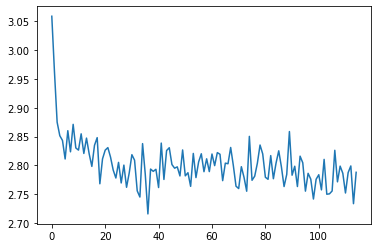

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [ ]:
total = 0
correct = 0
for i_batch, sample in enumerate(train_loader):
  x, y_truth = sample[0].to(device), sample[1].to(device)
 

  text = get_text(y_truth.squeeze(0))
  input_ids, attention_mask, y_truth, index = get_inputs(text)

  input_ids = input_ids.to(device)
  attention_mask = attention_mask.to(device)

  output, y_hat = model(input_ids, attention_mask)

  if(text[index] == get_text(y_truth.argmax(-1))):
    correct = correct + 1

  total = total + 1

print(correct/total)

0.029001483994064024


In [ ]:
# correct = 0
# for x, y_truth in val_loader:
#   x, y_truth = x.to(device), y_truth.to(device)
#   output, y_hat = model(input_embeddings = x)
#   correct = correct + int(torch.sum(output.argmax(-1).squeeze(0) ==  y_truth.argmax(-1)))

# print(correct/len(val_loader.dataset))

total = 0
correct = 0
for i_batch, sample in enumerate(test_loader):
  x, y_truth = sample[0].to(device), sample[1].to(device)
 

  text = get_text(y_truth.squeeze(0))
  input_ids, attention_mask, y_truth, index = get_inputs(text)

  input_ids = input_ids.to(device)
  attention_mask = attention_mask.to(device)

  output, y_hat = model(input_ids, attention_mask)

  # print("Text: ", text, index)
  # print("Label: ", text[index])
  # print("Prediction: ", get_text(y_truth.argmax(-1)))

  if(text[index] == get_text(y_truth.argmax(-1))):
    correct = correct + 1

  total = total + 1

print(correct/total)

0.026033495866016537
